# June 15th, 2021

**Motivation**: Using Mice object, apply agglomerative hierarchical clustering algorithm to fMRI data. This update is a precurser to the next one (skip this). </br>

In [1]:
# HIDE CODE


import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from copy import deepcopy as dc
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.processing import *
from utils.network import *
from utils.plotting import *
from model.mouse import Mice

# Allen
allen_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/allen')
allen_path = pjoin(allen_ws, 'MouseConnectivity')
os.makedirs(allen_path, exist_ok=True)
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]


def reset_ants_img(img: Union[np.ndarray, ants.ANTsImage], dtype=float, origin=0.0, spacing=1.0):
    ndims = len(img.shape)
    if isinstance(img, ants.ANTsImage):
        img = img.numpy()
    return ants.from_numpy(img.astype(dtype), origin=[origin]*ndims, spacing=[spacing]*ndims)


def add_children(graph: nx.DiGraph(), src_id: int, level: int, structure_tree):
    src = structure_tree.get_structures_by_id([src_id])[0]
    children = structure_tree.children([src_id])[0]
    for child in children:
        src_name = '\n'.join(src['name'].split(' '))
        tgt_name = '\n'.join(child['name'].split(' '))
        graph.add_node(tgt_name, lvl=level)
        graph.add_edge(src_name, tgt_name)
    return graph, children


def make_tree_graph(root: str, mcc: MouseConnectivityCache, n_levels: int = 3):
    structure_tree = mcc.get_structure_tree()
    structure = structure_tree.get_structures_by_name([root])[0]
    
    g = nx.DiGraph()
    g.add_node('\n'.join(structure['name'].split(' ')), lvl=0)

    dend = {}
    for lvl in range(n_levels):
        if lvl == 0:
            src_ids = [structure['id']]
        else:
            new_leaves = []
            for i in src_ids:
                g, children = add_children(
                    graph=g,
                    src_id=i,
                    level=lvl,
                    structure_tree=structure_tree,
                )
                for child in children:
                    new_leaves.append(child['id'])
            src_ids = new_leaves
        dend[lvl] = src_ids
 
    return g, dend


def reorient_arr(x: np.ndarray, tr_axes: Tuple = (2, 1, 0)):
    if len(x.shape) == 4:
        tr_axes += (3,)
    return np.transpose(x, tr_axes)[::-1]


def mask_left_right(mask: np.ndarray, left_right_axis: int = 2):
    npix = mask.shape[left_right_axis]
    coverage = int(np.ceil(npix/2))
    slices_l = tuple(
        slice(0, coverage) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    slices_r = tuple(
        slice(npix-coverage, npix) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    mask_l = mask.copy().astype(bool)
    mask_r = mask.copy().astype(bool)
    mask_l[slices_r] = 0
    mask_r[slices_l] = 0
    
    return mask_l.astype(bool), mask_r.astype(bool)


from time import time
from sklearn.cluster import KMeans
import sklearnex


def kmeans_parcellation(
    mask: np.ndarray,
    num_regions: int = 256,
    symmetrize: bool = False,
    left_right_axis: int = 2,
    random_state: int = 42, ):
    
    sklearnex.patch_sklearn()
    mask_l, mask_r = mask_left_right(mask, left_right_axis)
    
    if symmetrize:
        mask_r_full = mask_r.copy()
        mask_l_full = mask_l.copy()
        mask_r_full[slices_l] = np.flip(mask_r[slices_r], axis=left_right_axis)
        mask_l_full[slices_r] = np.flip(mask_l[slices_l], axis=left_right_axis)
        mask_sym = np.logical_and(mask_r_full, mask_l_full)
        
        mask_l = mask_sym.copy().astype(bool)
        mask_r = mask_sym.copy().astype(bool)
        mask_l[slices_r] = 0
        mask_r[slices_l] = 0
        
        # do left
        atlas_kmeans, cluster_centers = _do_kmeans(mask_l, num_regions, random_state)
        
        # mirror symmetry clusters to right hemisphere
        for region_id in np.unique(atlas_kmeans[atlas_kmeans > 0]):
            
            region_id_r = region_id + num_regions
            flipped = np.flip(atlas_kmeans[slices_l], axis=left_right_axis)
            atlas_kmeans[slices_r][flipped == region_id] = region_id_r
            
            # get center for right cluster
            _ctr = cluster_centers[region_id].copy()
            delta = npix/2 - _ctr[left_right_axis]
            _ctr[left_right_axis] += 2*delta - 1
            cluster_centers[region_id_r] = _ctr

    else:
        atlas_kmeans_l, cluster_centers_l = _do_kmeans(mask_l, num_regions, random_state)
        atlas_kmeans_r, cluster_centers_r = _do_kmeans(mask_r, num_regions, random_state)
        
        atlas_kmeans_r += num_regions 
        cluster_centers_r = {i+num_regions: ctr for i, ctr in cluster_centers_r.items()}
        
        atlas_kmeans = atlas_kmeans_l.copy()
        atlas_kmeans[mask_r] = atlas_kmeans_r[mask_r]
        cluster_centers = {**cluster_centers_l, **cluster_centers_r}

    sklearnex.unpatch_sklearn()
    output = {
        'atlas_kmeans': atlas_kmeans.astype(int),
        'cluster_centers': cluster_centers,
        'mask_l': mask_l.astype(bool),
        'mask_r': mask_r.astype(bool),
    }
    return output


def _do_kmeans(x, num_regions, random_state):
    nonzero_voxels = list(zip(*np.where(x.astype(bool))))
    nonzero_voxels = np.reshape(nonzero_voxels, (-1, len(x.shape)))
    nonzero_voxels = nonzero_voxels.astype(int)

    kmeans = KMeans(
        n_clusters=num_regions,
        random_state=random_state,
    ).fit(nonzero_voxels.astype(float))
    roi = kmeans.predict(nonzero_voxels.astype(float))

    roi_unique = []
    for lbl in roi:
        if lbl not in roi_unique:
            roi_unique.append(lbl)
    mapping = {lbl: i+1 for i, lbl in enumerate(roi_unique)}

    roi_relabeld = np.zeros_like(roi)
    for lbl in roi_unique:
        roi_relabeld[roi == lbl] = mapping[lbl]

    atlas_kmeans_dict = defaultdict(list)
    for voxel, lbl in zip(nonzero_voxels, roi_relabeld):
        atlas_kmeans_dict[lbl].append(tuple(voxel))
    atlas_kmeans_dict = dict(atlas_kmeans_dict)

    atlas_kmeans = np.zeros(x.shape, dtype=int)
    for region_id, voxel_list in atlas_kmeans_dict.items():
        atlas_kmeans[tuple(zip(*voxel_list))] = region_id

    cluster_centers = {mapping[lbl]: kmeans.cluster_centers_[lbl] for lbl in roi_unique}
    
    return atlas_kmeans, cluster_centers


def translate_labels(labels: List[str], mcc: MouseConnectivityCache):
    labels = list(labels) if not isinstance(labels, (list, tuple, dict)) else labels
    structure_tree = mcc.get_structure_tree()

    left_right = []
    structure_ids = []
    region_ids = []
    for label in labels:
        try:
            lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        except ValueError:
            lr, structure_id = tuple(map(lambda x: int(x), label.split('-')))
            region_id = None
        left_right.append('L' if lr == 0 else 'R')
        structure_ids.append(structure_id)
        region_ids.append(region_id)
        
    structures = structure_tree.get_structures_by_id(structure_ids)
    translated = [
        '{:s}-{:s}'.format(lr, struct['name']) if region_id is None else
        '{:s}-{:s}-{:d}'.format(lr, struct['name'], region_id)
        for lr, struct, region_id in zip(left_right, structures, region_ids)
    ]
    return translated


def load_allen(ws_dir: str, mode: str = 'MouseConnectivity', resolution: int = 100):
    manifest_file = pjoin(ws_dir, mode, 'manifest.json')
    mcc = MouseConnectivityCache(resolution=resolution, manifest_file=manifest_file)
    structure_tree = mcc.get_structure_tree()
    
    root = structure_tree.get_structures_by_name(['root'])[0]
    cerebrum = structure_tree.get_structures_by_name(['Cerebrum'])[0]
    isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]

    template, template_info = mcc.get_template_volume()
    annot, annot_info = mcc.get_annotation_volume()

    root_mask, root_mask_info = mcc.get_structure_mask(root['id'])
    cerebrum_mask, cerebrum_mask_info = mcc.get_structure_mask(cerebrum['id'])
    isocortex_mask, isocortex_mask_info = mcc.get_structure_mask(isocortex['id'])
    
    output = {
        'manifest_file': manifest_file,
        'mcc': mcc,
        'structure_tree': structure_tree,
        
        'root': root,
        'cerebrum': cerebrum,
        'isocortex': isocortex,
        
        'template': template,
        'template_info': template_info,
        
        'annot': annot,
        'annot_info': annot_info,
        
        'root_mask': root_mask,
        'root_mask_info': root_mask_info,
        
        'cerebrum_mask': cerebrum_mask,
        'cerebrum_mask_info': cerebrum_mask_info,
        
        'isocortex_mask': isocortex_mask,
        'isocortex_mask_info': isocortex_mask_info,
    }
    return output


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(6, 4),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def plot_registration(
    fixed: np.ndarray,
    moving: np.ndarray,
    warped: np.ndarray,
    figsize=(6, 8), ):
    
    sns.set_style('white')
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for i in range(3):
        for j in range(3):       
            if i == 0:
                x = fixed.numpy()
                label = 'fixed'
            elif i == 1:
                x = moving.numpy()
                label = 'moving'
            else:
                x = warped.numpy()
                label = 'warped'

            if i == 0:
                if j == 0:
                    top_title = 'axis = {:d}\n(coronal)'.format(j)
                elif j == 1:
                    top_title = 'axis = {:d}\n(axial)'.format(j)
                else:
                    top_title = 'axis = {:d}\n(saggital)'.format(j)
                axes[i, j].set_title(top_title, y=1.1, fontsize=13)

            if j == 0:
                axes[i, j].set_ylabel(label + '\n', fontsize=13)

            data2plt = x.mean(j)
            axes[i, j].imshow(data2plt)

            _ = list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    msg = 'Plotting averaged data across different dimensions\n\n'
    msg += '1st row (fixed):  Average template,    shape = {}\n'.format(fixed.shape)
    msg += '2nd row (moving):  Anatomical data,    shape = {}\n'.format(moving.shape)
    msg += '3rd row (warped):  Anatomical data,    shape = {}'.format(warped.shape)
    plt.suptitle(msg, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [3]:
import allensdk
print(allensdk.__version__)

2.11.2


## Load Allen data

In [4]:
allen = load_allen(allen_ws)

## ROI definition (CCF space)

In [5]:
num_regions = 64

parcellation = kmeans_parcellation(
    mask=allen['isocortex_mask'],
    num_regions=num_regions,
    symmetrize=False,
    left_right_axis=2,
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [6]:
dict_list = []
for radius in tqdm(np.linspace(1, 20, num=101)):
    atlas_kmeans_eroded = np.zeros_like(parcellation['atlas_kmeans'])
    accepted, rejected = 0, 0
    for region_id, ctr in tqdm(parcellation['cluster_centers'].items(), leave=False):
        for voxel in list(zip(*np.where(parcellation['atlas_kmeans'] == region_id))):
            dist = np.linalg.norm(ctr - voxel)
            if dist < radius:
                atlas_kmeans_eroded[voxel] = region_id
                accepted += 1
            else:
                rejected += 1

    accepted /= parcellation['atlas_kmeans'].astype(bool).sum()
    rejected /= parcellation['atlas_kmeans'].astype(bool).sum()
    
    # find variation in ROI sizes  
    x = atlas_kmeans_eroded.copy().astype(float)
    vals = []
    for region_id in np.unique(x[x > 0]):
        size = (x == region_id).sum() / allen['isocortex_mask'].sum()
        if size >= 0.5:
            print('bad', radius, region_id)
            break
        vals.append(size * 100)

    # save data    
    data_dict = {
        'radius': [radius],
        'accepted': [accepted * 100],
        'rejected': [rejected * 100],
        'size_min': [np.min(vals)],
        'size_max': [np.max(vals)],
        'size_mean': [np.mean(vals)],
        'size_var': [np.var(vals)],
    }
    dict_list.append(data_dict)
df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [7]:
idx = (df.accepted - df.rejected).abs().values.argmin()
idx

21

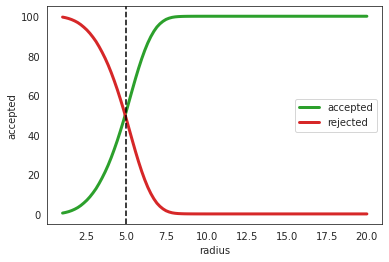

In [8]:
sns.lineplot(data=df, x='radius', y='accepted', color='C2', label='accepted', lw=3)
sns.lineplot(data=df, x='radius', y='rejected', color='C3', label='rejected', lw=3)
plt.axvline(df.loc[idx, 'radius'], color='k', ls='--')

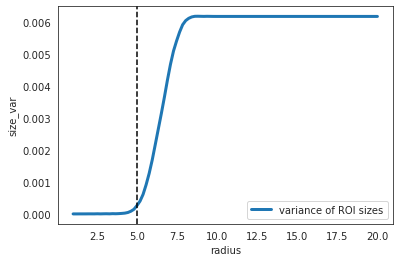

In [9]:
sns.lineplot(data=df, x='radius', y='size_var', label='variance of ROI sizes', lw=3, color='C0')
plt.axvline(df.loc[idx, 'radius'], color='k', ls='--')

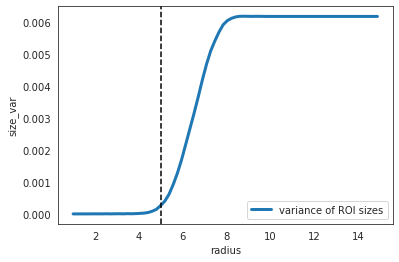

In [10]:
selected_df = df.loc[df.radius < 15.]
sns.lineplot(data=selected_df, x='radius', y='size_var', label='variance of ROI sizes', lw=3, color='C0')
plt.axvline(df.loc[idx, 'radius'], color='k', ls='--')

In [11]:
radius = df.loc[idx, 'radius']
radius

4.99

In [12]:
radius = 5
radius

5

In [13]:
atlas_kmeans_eroded = np.zeros_like(parcellation['atlas_kmeans'])

accepted = 0
rejected = 0
for region_id, ctr in tqdm(parcellation['cluster_centers'].items(), leave=False):
    for voxel in list(zip(*np.where(parcellation['atlas_kmeans'] == region_id))):
        dist = np.linalg.norm(ctr - voxel)
        if dist < radius:
            atlas_kmeans_eroded[voxel] = region_id
            accepted += 1
        else:
            rejected += 1

accepted /= parcellation['atlas_kmeans'].astype(bool).sum()
rejected /= parcellation['atlas_kmeans'].astype(bool).sum()
accepted *= 100
rejected *= 100

accepted, rejected

  0%|          | 0/128 [00:00<?, ?it/s]

(52.5327599496937, 47.4672400503063)

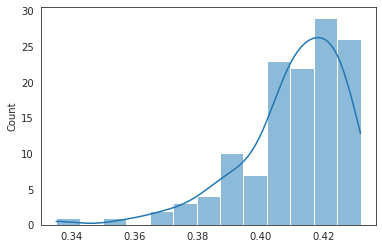

In [14]:
x = atlas_kmeans_eroded.copy().astype(float)
vals, percentages = [], []
for region_id in np.unique(x[x > 0]):
    vals.append((x == region_id).sum())
    size = (x == region_id).sum() / allen['isocortex_mask'].sum()
    if size >= 0.5:
        print('bad', region_id)
        break
    percentages.append(size * 100)

sns.histplot(percentages, kde=True);

In [15]:
np.min(percentages), np.max(percentages), np.var(percentages)

(0.33510487240861697, 0.43166051361109986, 0.0002736681559132824)

In [16]:
np.min(vals), np.max(vals), np.var(vals)

(413, 532, 415.68359375)

## Define ROIs

In [17]:
selected_names = [
    'Striatum',
    'Pallidum',
    'Olfactory areas',
    'Cortical subplate',
    'Hippocampal formation',
    'Isocortex',
]
selected_names

['Striatum',
 'Pallidum',
 'Olfactory areas',
 'Cortical subplate',
 'Hippocampal formation',
 'Isocortex']

In [18]:
root_mask_l, root_mask_r = mask_left_right(allen['root_mask'])
selected_structures = allen['structure_tree'].get_structures_by_name(selected_names)

roi_masks = {}
for structure_dict in selected_structures:
    print('id: {:d},\tname: {:s}'.format(structure_dict['id'], structure_dict['name']))
    if structure_dict['name'] == 'Isocortex':
        for region_id_l in range(1, num_regions+1):
            region_id_r = region_id_l + num_regions
            _mask_l = atlas_kmeans_eroded == region_id_l
            _mask_r = atlas_kmeans_eroded == region_id_r
            roi_masks['0-{:d}-{:d}'.format(structure_dict['id'], region_id_l)] = _mask_l.astype(bool)
            roi_masks['1-{:d}-{:d}'.format(structure_dict['id'], region_id_r)] = _mask_r.astype(bool)
    else:
        _mask = allen['mcc'].get_structure_mask(structure_dict['id'])[0]
        _mask_l = np.logical_and(_mask, root_mask_l)
        _mask_r = np.logical_and(_mask, root_mask_r)
        roi_masks['0-{:d}'.format(structure_dict['id'])] = _mask_l.astype(bool)
        roi_masks['1-{:d}'.format(structure_dict['id'])] = _mask_r.astype(bool)

id: 477,	name: Striatum
id: 803,	name: Pallidum
id: 698,	name: Olfactory areas
id: 703,	name: Cortical subplate
id: 1089,	name: Hippocampal formation
id: 315,	name: Isocortex


In [19]:
roi_masks.keys()

dict_keys(['0-477', '1-477', '0-803', '1-803', '0-698', '1-698', '0-703', '1-703', '0-1089', '1-1089', '0-315-1', '1-315-65', '0-315-2', '1-315-66', '0-315-3', '1-315-67', '0-315-4', '1-315-68', '0-315-5', '1-315-69', '0-315-6', '1-315-70', '0-315-7', '1-315-71', '0-315-8', '1-315-72', '0-315-9', '1-315-73', '0-315-10', '1-315-74', '0-315-11', '1-315-75', '0-315-12', '1-315-76', '0-315-13', '1-315-77', '0-315-14', '1-315-78', '0-315-15', '1-315-79', '0-315-16', '1-315-80', '0-315-17', '1-315-81', '0-315-18', '1-315-82', '0-315-19', '1-315-83', '0-315-20', '1-315-84', '0-315-21', '1-315-85', '0-315-22', '1-315-86', '0-315-23', '1-315-87', '0-315-24', '1-315-88', '0-315-25', '1-315-89', '0-315-26', '1-315-90', '0-315-27', '1-315-91', '0-315-28', '1-315-92', '0-315-29', '1-315-93', '0-315-30', '1-315-94', '0-315-31', '1-315-95', '0-315-32', '1-315-96', '0-315-33', '1-315-97', '0-315-34', '1-315-98', '0-315-35', '1-315-99', '0-315-36', '1-315-100', '0-315-37', '1-315-101', '0-315-38', '1-3

In [20]:
len(roi_masks)

138

## FC analysis

### Load anat

In [21]:
fixed = reset_ants_img(allen['template'])

In [22]:
mice = Mice()

In [23]:
config = Config()

n_seeds = 5
seeds = [2**i for i in range(n_seeds)]

moving_imgs = {}
warped_imgs = {}
transforms = {}
for key, anat in tqdm(mice.T1w.items()):
    subject, session, _ = mice.looper[key]
    if subject not in [6, 7]:
        continue

    moving = anat.get_data()
    moving = reorient_arr(moving)
    moving = reset_ants_img(moving)
    moving_imgs[key] = moving

    _txs = []
    _perf = []
    for seed in seeds:
        tx = ants.registration(
            fixed=fixed,
            moving=moving,
            mask=moving.get_mask(),
            type_of_transform='SyN',
            verbose=True,
            random_seed=seed,
        )
        warped = ants.apply_transforms(
            fixed=fixed,
            moving=moving,
            transformlist=tx['fwdtransforms'],
            interpolator='linear',
        )
        mi = ants.image_mutual_information(fixed, warped)
        mi_base = ants.image_mutual_information(fixed, fixed)

        _txs.append(tx)
        _perf.append(mi/mi_base)

    best_tx = _txs[np.argmax(_perf)]
    transforms[key] = best_tx
    
    warped = ants.apply_transforms(
        fixed=fixed,
        moving=moving,
        transformlist=best_tx['fwdtransforms'],
        interpolator='linear',
    )
    warped_imgs[key] = warped
    
    mi = ants.image_mutual_information(fixed, warped)
    mi_base = ants.image_mutual_information(fixed, fixed)
    print('{:s},\tbest rel mi: {:.3f}'.format(key, mi/mi_base))

  0%|          | 0/30 [00:00<?, ?it/s]

sub-SLC06_ses-1,	best rel mi: 0.449
sub-SLC06_ses-2,	best rel mi: 0.429
sub-SLC06_ses-3,	best rel mi: 0.447
sub-SLC07_ses-1,	best rel mi: 0.434
sub-SLC07_ses-2,	best rel mi: 0.451
sub-SLC07_ses-3,	best rel mi: 0.433


### Inv mask transforms

In [24]:
masks_inv = {}
for key, best_tx in transforms.items():
    inv = {}
    inv['roi'] = {
        lbl: ants.apply_transforms(
            fixed=moving,
            moving=reset_ants_img(mask),
            transformlist=best_tx['invtransforms'],
            interpolator='genericLabel', )
        for lbl, mask in roi_masks.items()
    }
    _masks = [
        parcellation['mask_l'],
        parcellation['mask_r'],
        allen['root_mask'],
        allen['cerebrum_mask'],
        allen['isocortex_mask'],
    ]
    left_inv, right_inv, root_inv, cerebrum_inv, isocortex_inv = [
        ants.apply_transforms(
            fixed=moving,
            moving=reset_ants_img(mask),
            transformlist=best_tx['invtransforms'],
            interpolator='genericLabel', )
        for mask in _masks
    ]
    inv['left'] = left_inv
    inv['right'] = right_inv
    inv['root'] = root_inv
    inv['cerebrum'] = cerebrum_inv
    inv['isocortex'] = isocortex_inv
    
    masks_inv[key] = inv

In [25]:
atlas_inv = {}
for key, val in masks_inv.items():
    atlas_kmeans_inv = np.zeros(moving.shape)
    for lbl, mask_inv in val['roi'].items():
        if str(allen['isocortex']['id']) not in lbl:
            continue
        region_id = int(lbl.split('-')[-1])
        atlas_kmeans_inv[mask_inv.numpy().astype(bool)] = region_id
    atlas_inv[key] = atlas_kmeans_inv

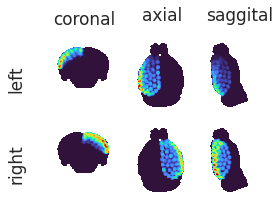

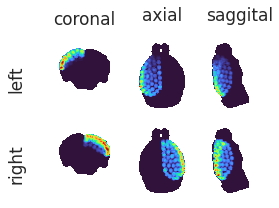

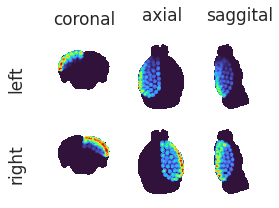

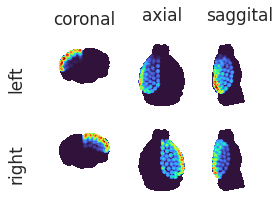

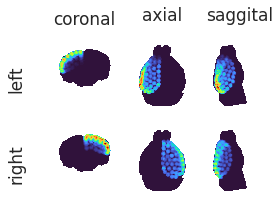

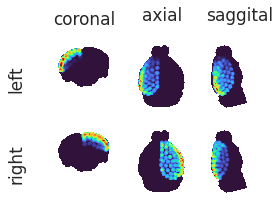

In [26]:
for key, atlas_kmeans_inv in atlas_inv.items():
    _ = plot_parcellation(
        parcellation=atlas_kmeans_inv,
        mask_l=masks_inv[key]['left'].numpy().astype(bool),
        mask_r=masks_inv[key]['right'].numpy().astype(bool),
        root_mask=masks_inv[key]['root'].numpy().astype(bool),
        figsize=(4, 3),
    )

### Load func

In [27]:
config = Config()
include_intvl = range(config.exclude, config.run_duration)

normal = True

dict_list = []
for key, bold in tqdm(mice.bold.items()):
    subject, session, run = mice.looper[key]
    if subject not in [6, 7]:
        continue

    x = bold.get_data()
    if bold.task != 'rest' or x is None:
        continue
    x = reorient_arr(x)
    
    key_mask = mice.get_key(subject, session)
    mask_CH = masks_inv[key_mask]['cerebrum'].numpy().astype(bool)
    
    if normal:
        mean = x[mask_CH, :].mean()
        sd = x[mask_CH, :].std()
        x = (x - mean) / sd

    # put into df
    for region_id, mask in masks_inv[key_mask]['roi'].items():
        data_dict = {
            'bold': x[mask.numpy().astype(bool), :].mean(0)[include_intvl], # TODO: how about median?
            'timepoint': range(config.run_duration*(run-1) + config.exclude, config.run_duration*run),
            'region_id': [region_id] * len(include_intvl),
            'subject': [subject] * len(include_intvl),
            'session': [session] * len(include_intvl),
            'run': [run] * len(include_intvl),
            'normal': [str(normal)] * len(include_intvl),
        }
        dict_list.append(data_dict)
df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/210 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [28]:
df.shape

(1821600, 7)

In [29]:
df_table = {}

for key, (subject, session, run) in mice.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = selected_df.pivot(index='timepoint', columns='region_id', values='bold')

node_labels = list(df_table.values())[0].columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

### Subject 6, session 1, runs [1, 3, 5, 7]

In [30]:
df_list = [
    _df for key, _df in df_table.items()
    if mice.looper[key][0] in [6] and mice.looper[key][1] in [1]
]
df_combined = pd.concat(df_list)
df_combined.shape

(2200, 138)

In [31]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [32]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_combined, percentiles=percentiles, positive_only=False)

In [33]:
corrs.keys()

dict_keys(['percentiles', 'pearson_thresholds', 'spearman_thresholds', 'pearson', 'spearman', 'pearson_corr', 'spearman_corr'])

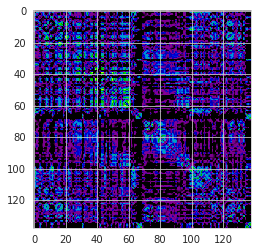

In [34]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)

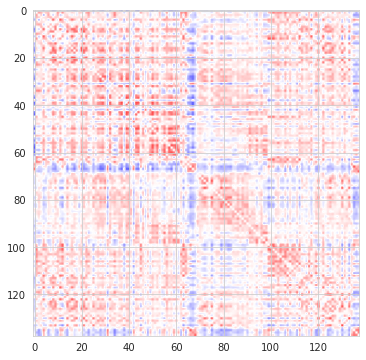

In [35]:
plt.figure(figsize=(8, 6))
plt.imshow(corrs['pearson_corr'], cmap='bwr', vmin=-1, vmax=1)

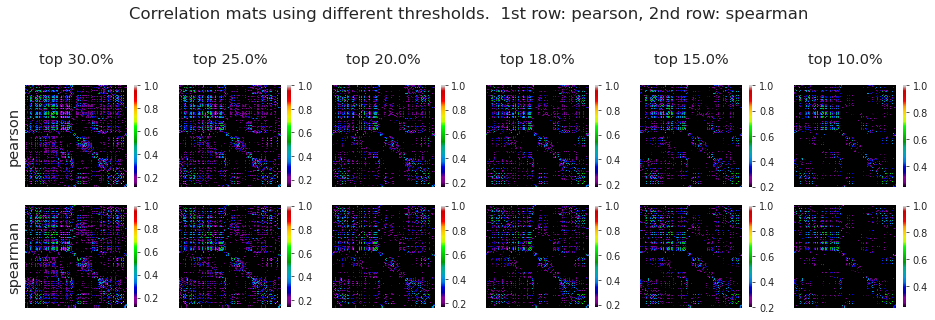

In [36]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

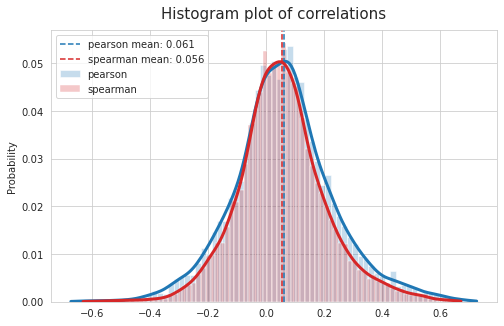

In [37]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(8, 5),
)

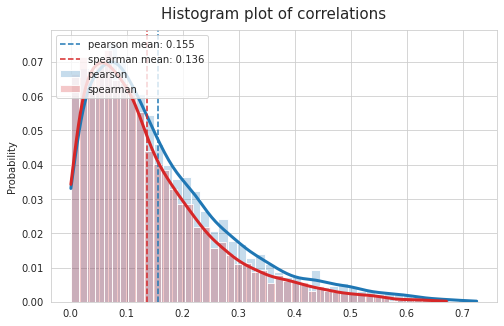

In [38]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(8, 5),
)

#### Hierarchical clustering

In [39]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy as sp_hier

In [40]:
x_dict = {
    k: np.array(list(v.values())).reshape(1, -1)
    for k, v in df_combined.reset_index(drop=True).to_dict().items()
}

In [41]:
x = np.concatenate(list(x_dict.values()))
y = pdist(X=x, metric='correlation')
z = sp_hier.linkage(y, method='ward', metric='euclidean', optimal_ordering=False)

x.shape, y.shape, z.shape

((138, 2200), (9453,), (137, 4))

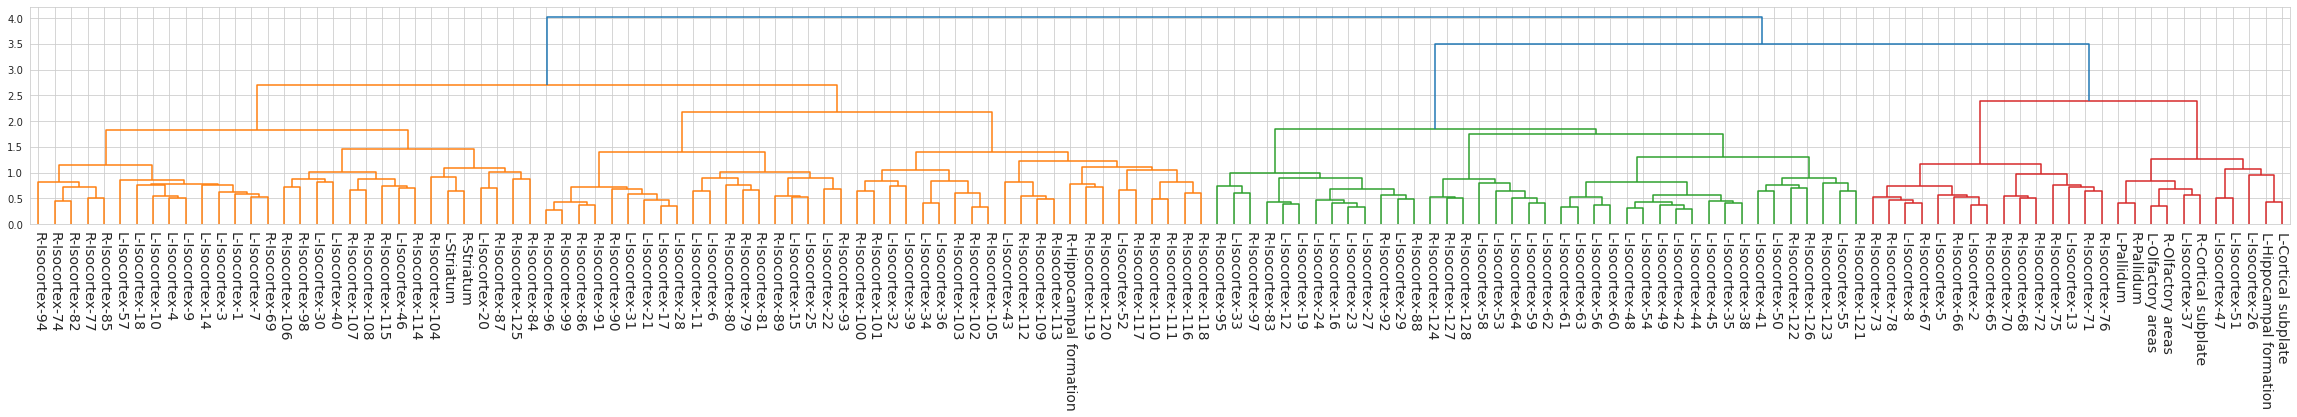

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(13.5 * 3, 4))

dn = sp_hier.dendrogram(
    Z=z,
    p=30,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=translate_labels(x_dict, allen['mcc']),
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=False,
    leaf_font_size=14,
    leaf_rotation=-90,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=ax,
    above_threshold_color='C0',
)

In [44]:
partition = {node: color for node, color in zip(dn['leaves'], dn['leaves_color_list'])}
color2idx = {c: i+1 for i, c in enumerate(set(partition.values()))}

partition = {node: color2idx[c] for node, c in partition.items()}
partition = dict(sorted(partition.items()))
partition = {node_labels[node]: comm_idx for node, comm_idx in partition.items()}

In [45]:
comms3d = np.zeros(fixed.shape)
for label, comm_idx in partition.items():  
    if str(allen['isocortex']['id']) in label:
        lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        comms3d[parcellation['atlas_kmeans'] == region_id] = comm_idx
    else:
        comms3d[roi_masks[label]] = comm_idx

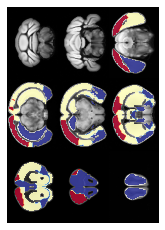

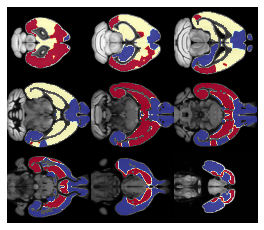

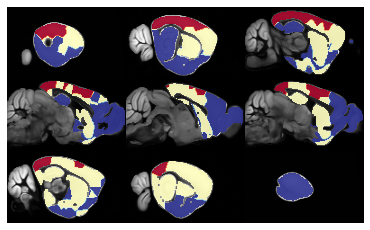

In [46]:
x = comms3d.copy()
x[~allen['cerebrum_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=9,
        figsize=1,
        axis=axis,
    )

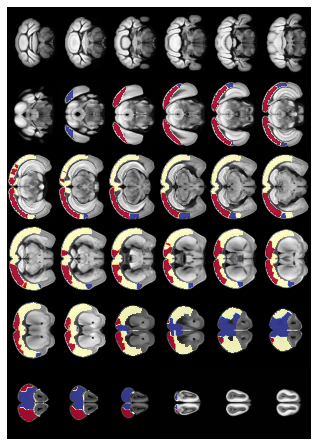

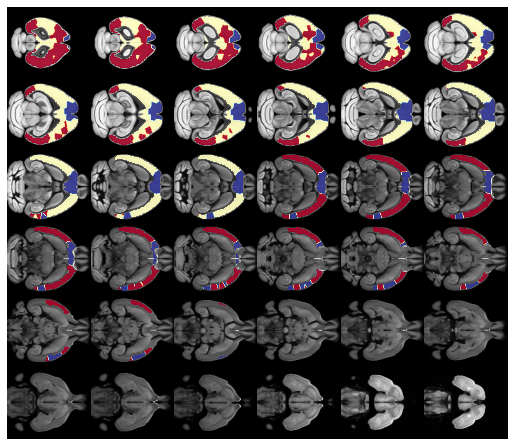

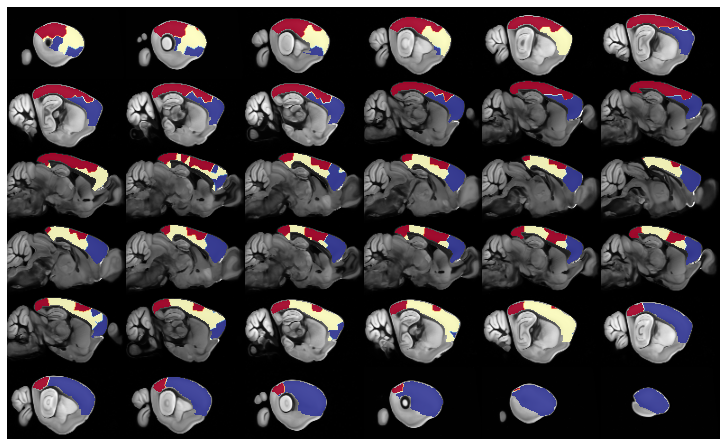

In [47]:
x = comms3d.copy()
x[~allen['isocortex_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=36,
        figsize=1,
        axis=axis,
    )

In [47]:
comms3d.shape

(132, 80, 114)

In [48]:
np.save('comms3d_{:d}.npy'.format(num_regions), comms3d)

### Subject 6, sessions [1, 2, 3], runs [1, 3, 5, 7]

In [49]:
df_list = [
    _df for key, _df in df_table.items()
    if mice.looper[key][0] in [6] and mice.looper[key][1] in [1, 2, 3]
]
df_combined = pd.concat(df_list)
df_combined.shape

(6600, 138)

In [52]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [53]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_combined, percentiles=percentiles, positive_only=False)

In [54]:
corrs.keys()

dict_keys(['percentiles', 'pearson_thresholds', 'spearman_thresholds', 'pearson', 'spearman', 'pearson_corr', 'spearman_corr'])

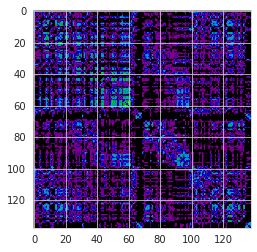

In [55]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)

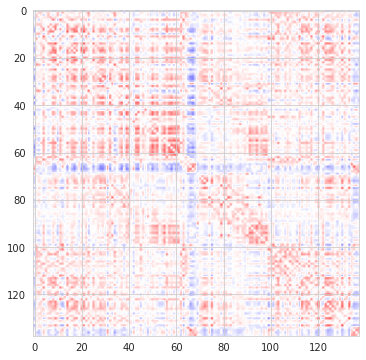

In [56]:
plt.figure(figsize=(8, 6))
plt.imshow(corrs['pearson_corr'], cmap='bwr', vmin=-1, vmax=1)

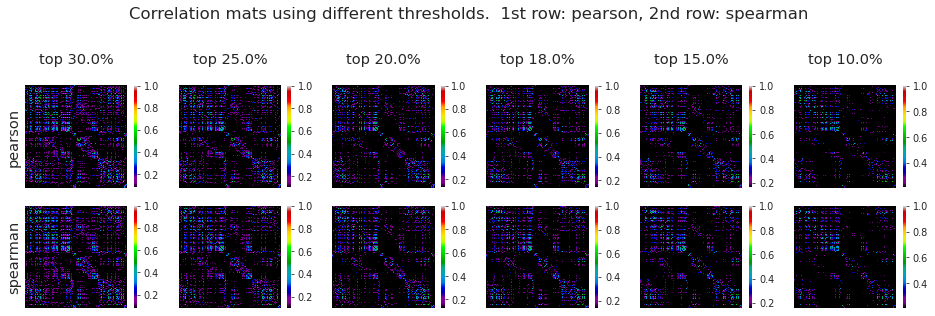

In [57]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

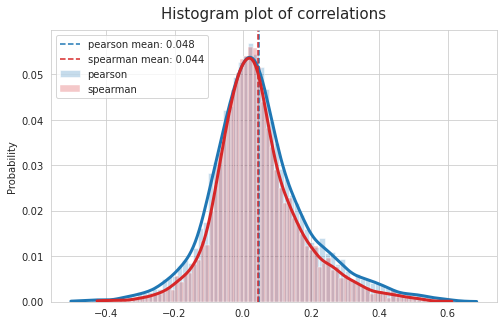

In [58]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(8, 5),
)

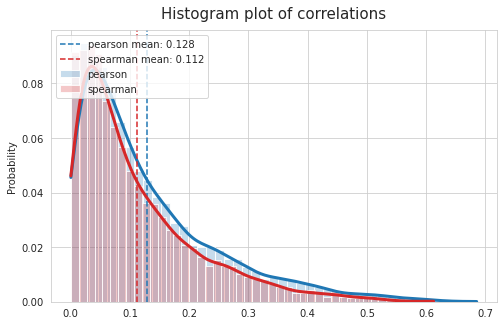

In [59]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(8, 5),
)

#### Hierarchical clustering

In [60]:
x_dict = {
    k: np.array(list(v.values())).reshape(1, -1)
    for k, v in df_combined.reset_index(drop=True).to_dict().items()
}

In [61]:
x = np.concatenate(list(x_dict.values()))
y = pdist(X=x, metric='correlation')
z = sp_hier.linkage(y, method='ward', metric='euclidean', optimal_ordering=False)

x.shape, y.shape, z.shape

((138, 6600), (9453,), (137, 4))

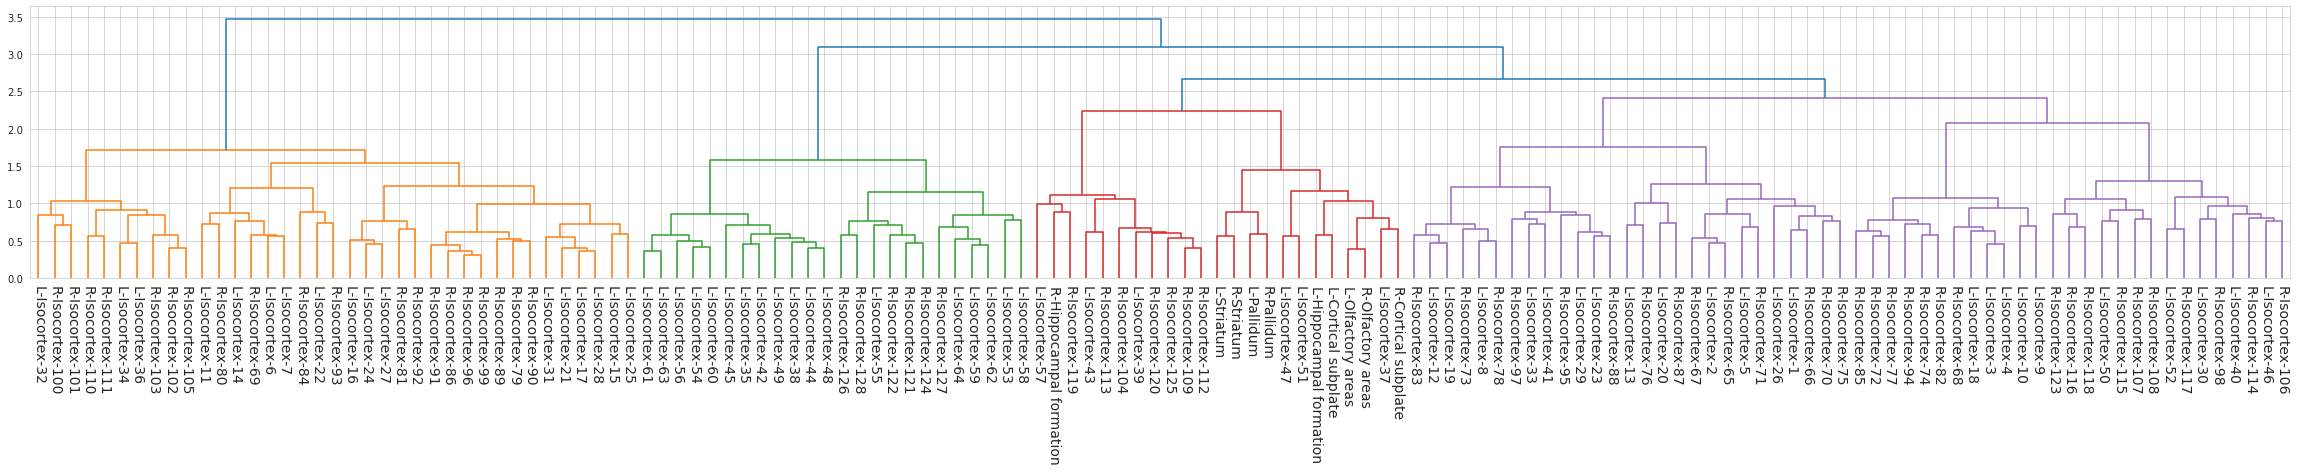

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(13.5 * 3, 5))

dn = sp_hier.dendrogram(
    Z=z,
    p=30,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=translate_labels(x_dict, allen['mcc']),
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=False,
    leaf_font_size=14,
    leaf_rotation=-90,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=ax,
    above_threshold_color='C0',
)

In [64]:
partition = {node: color for node, color in zip(dn['leaves'], dn['leaves_color_list'])}
color2idx = {c: i+1 for i, c in enumerate(set(partition.values()))}

partition = {node: color2idx[c] for node, c in partition.items()}
partition = dict(sorted(partition.items()))
partition = {node_labels[node]: comm_idx for node, comm_idx in partition.items()}

In [65]:
comms3d = np.zeros(fixed.shape)
for label, comm_idx in partition.items():  
    if str(allen['isocortex']['id']) in label:
        lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        comms3d[parcellation['atlas_kmeans'] == region_id] = comm_idx
    else:
        comms3d[roi_masks[label]] = comm_idx

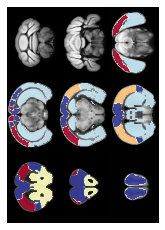

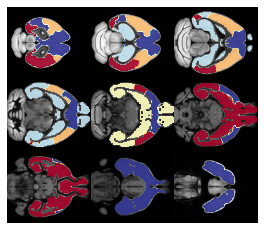

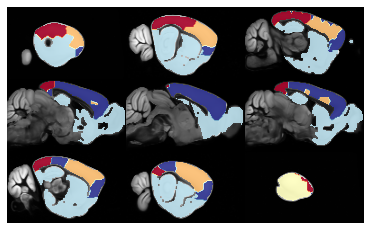

In [66]:
x = comms3d.copy()
x[~allen['cerebrum_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=9,
        figsize=1,
        axis=axis,
    )

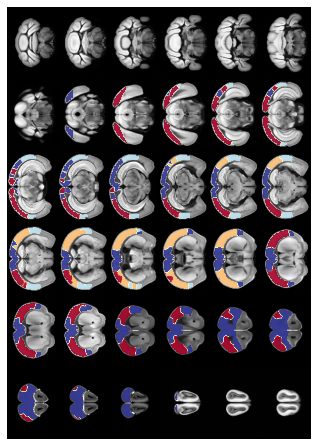

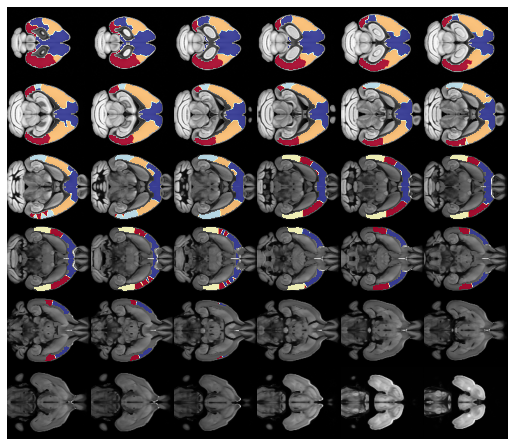

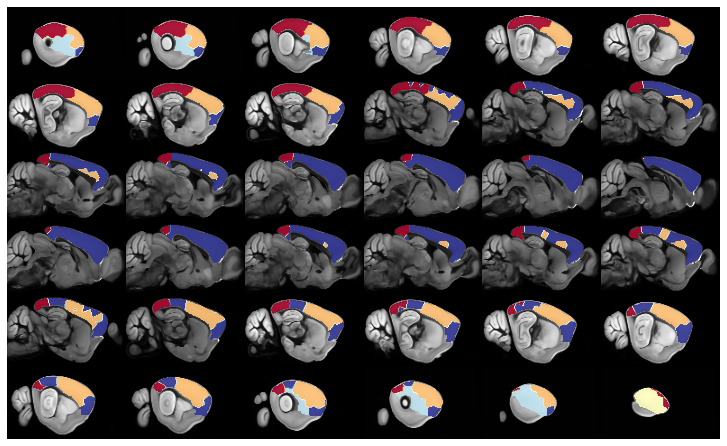

In [67]:
x = comms3d.copy()
x[~allen['isocortex_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=36,
        figsize=1,
        axis=axis,
    )

In [68]:
np.save('comms3d_{:d}_2.npy'.format(num_regions), comms3d)

### Subjects 6 & 7, all sessions and runs

In [69]:
df_list = [
    _df for key, _df in df_table.items()
    if mice.looper[key][0] in [6, 7] and mice.looper[key][1] in [1, 2, 3]
]
df_combined = pd.concat(df_list)
df_combined.shape

(13200, 138)

In [70]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [71]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_combined, percentiles=percentiles, positive_only=False)

In [72]:
corrs.keys()

dict_keys(['percentiles', 'pearson_thresholds', 'spearman_thresholds', 'pearson', 'spearman', 'pearson_corr', 'spearman_corr'])

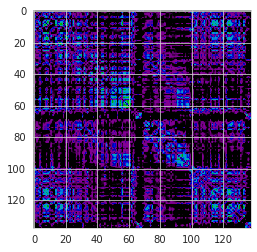

In [73]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)

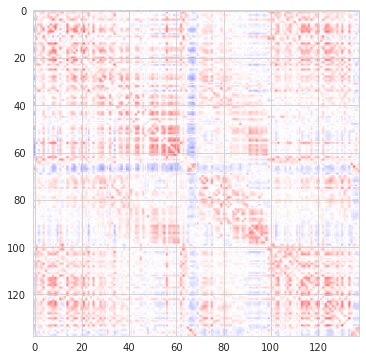

In [74]:
plt.figure(figsize=(8, 6))
plt.imshow(corrs['pearson_corr'], cmap='bwr', vmin=-1, vmax=1)

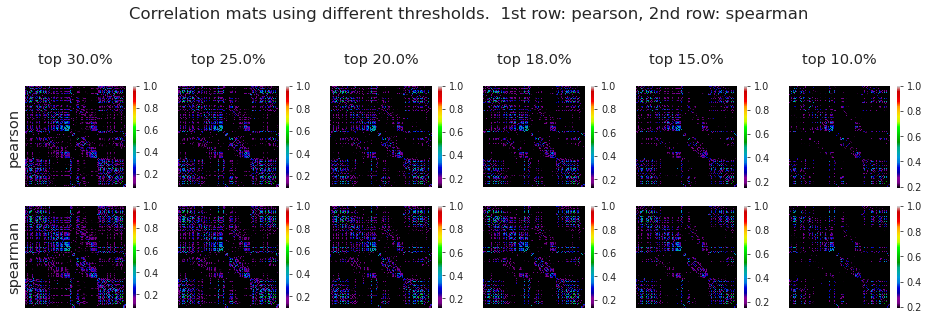

In [75]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

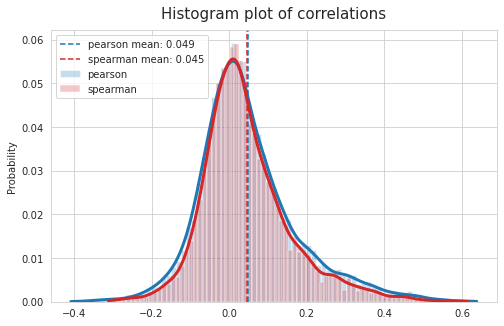

In [76]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(8, 5),
)

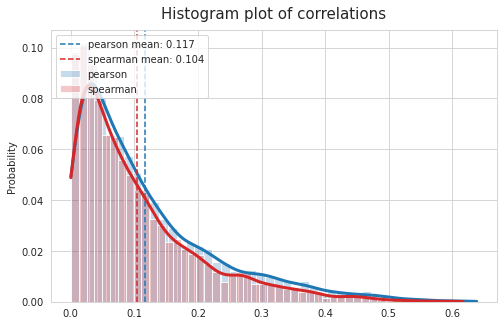

In [77]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(8, 5),
)

#### Hierarchical clustering

In [78]:
x_dict = {
    k: np.array(list(v.values())).reshape(1, -1)
    for k, v in df_combined.reset_index(drop=True).to_dict().items()
}

In [79]:
x = np.concatenate(list(x_dict.values()))
y = pdist(X=x, metric='correlation')
z = sp_hier.linkage(y, method='ward', metric='euclidean', optimal_ordering=False)

x.shape, y.shape, z.shape

((138, 13200), (9453,), (137, 4))

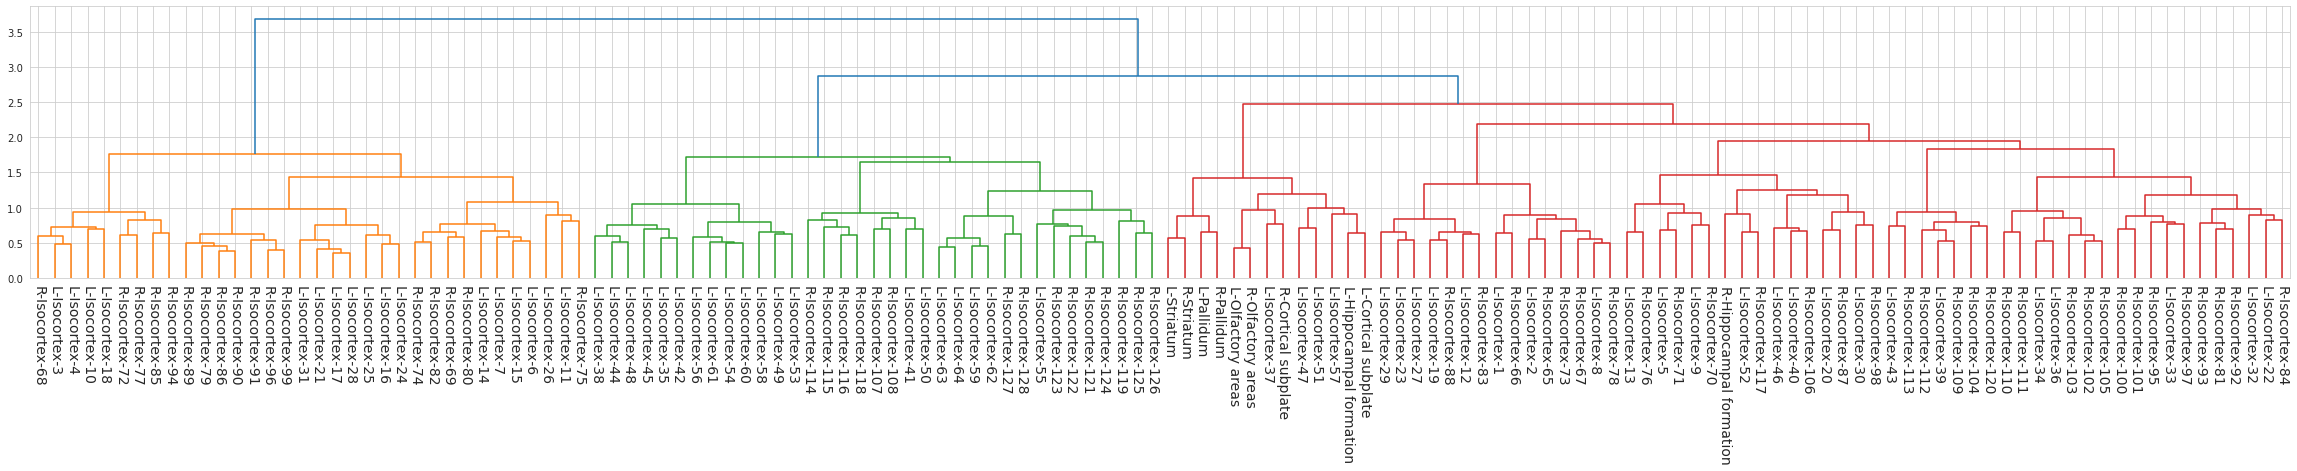

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(13.5 * 3, 5))

dn = sp_hier.dendrogram(
    Z=z,
    p=30,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=translate_labels(x_dict, allen['mcc']),
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=False,
    leaf_font_size=14,
    leaf_rotation=-90,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=ax,
    above_threshold_color='C0',
)

In [81]:
partition = {node: color for node, color in zip(dn['leaves'], dn['leaves_color_list'])}
color2idx = {c: i+1 for i, c in enumerate(set(partition.values()))}

partition = {node: color2idx[c] for node, c in partition.items()}
partition = dict(sorted(partition.items()))
partition = {node_labels[node]: comm_idx for node, comm_idx in partition.items()}

In [82]:
comms3d = np.zeros(fixed.shape)
for label, comm_idx in partition.items():  
    if str(allen['isocortex']['id']) in label:
        lr, structure_id, region_id = tuple(map(lambda x: int(x), label.split('-')))
        comms3d[parcellation['atlas_kmeans'] == region_id] = comm_idx
    else:
        comms3d[roi_masks[label]] = comm_idx

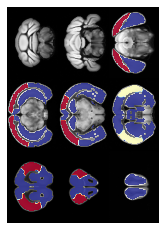

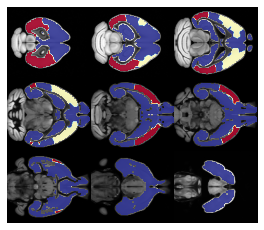

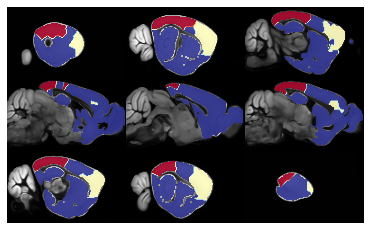

In [83]:
x = comms3d.copy()
x[~allen['cerebrum_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=9,
        figsize=1,
        axis=axis,
    )

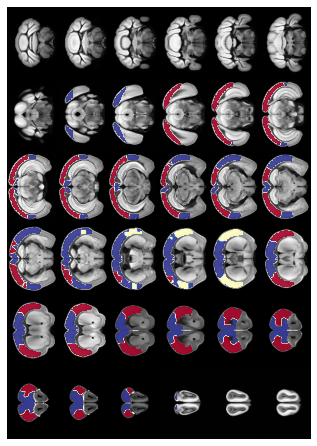

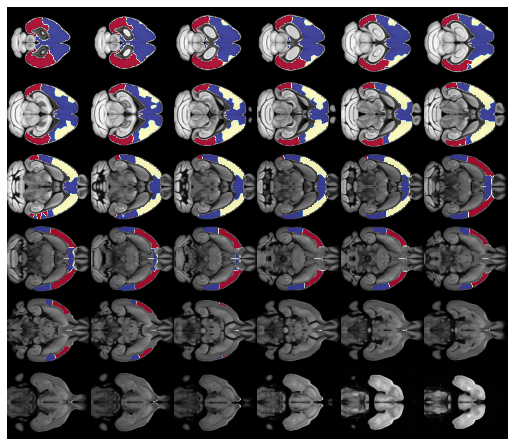

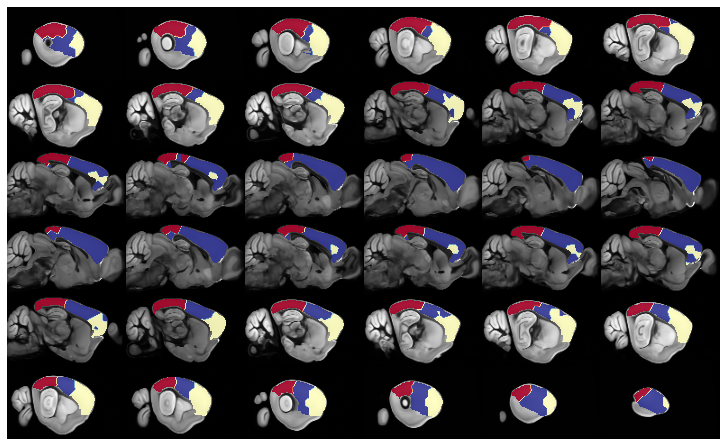

In [84]:
x = comms3d.copy()
x[~allen['isocortex_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=36,
        figsize=1,
        axis=axis,
    )

In [85]:
np.save('comms3d_{:d}_3.npy'.format(num_regions), comms3d)

## All data from all mice, all sessions

In [90]:
fixed = reset_ants_img(allen['template'])

In [91]:
mice = Mice()

In [93]:
config = Config()

n_seeds = 5
seeds = [2**i for i in range(n_seeds)]

moving_imgs = {}
warped_imgs = {}
transforms = {}
for key, anat in tqdm(mice.T1w.items()):
    subject, session, _ = mice.looper[key]

    moving = anat.get_data()
    moving = reorient_arr(moving)
    moving = reset_ants_img(moving)
    moving_imgs[key] = moving

    _txs = []
    _perf = []
    for seed in seeds:
        tx = ants.registration(
            fixed=fixed,
            moving=moving,
            mask=moving.get_mask(),
            type_of_transform='SyN',
            verbose=True,
            random_seed=seed,
        )
        warped = ants.apply_transforms(
            fixed=fixed,
            moving=moving,
            transformlist=tx['fwdtransforms'],
            interpolator='linear',
        )
        mi = ants.image_mutual_information(fixed, warped)
        mi_base = ants.image_mutual_information(fixed, fixed)

        _txs.append(tx)
        _perf.append(mi/mi_base)

    best_tx = _txs[np.argmax(_perf)]
    transforms[key] = best_tx
    
    warped = ants.apply_transforms(
        fixed=fixed,
        moving=moving,
        transformlist=best_tx['fwdtransforms'],
        interpolator='linear',
    )
    warped_imgs[key] = warped
    
    mi = ants.image_mutual_information(fixed, warped)
    mi_base = ants.image_mutual_information(fixed, fixed)
    print('{:s},\tbest rel mi: {:.3f}'.format(key, mi/mi_base))

  0%|          | 0/30 [00:00<?, ?it/s]

sub-SLC01_ses-1,	best rel mi: 0.444
sub-SLC01_ses-2,	best rel mi: 0.449
sub-SLC01_ses-3,	best rel mi: 0.446
sub-SLC02_ses-1,	best rel mi: 0.442
sub-SLC02_ses-2,	best rel mi: 0.441
sub-SLC02_ses-3,	best rel mi: 0.452
sub-SLC03_ses-1,	best rel mi: 0.434
sub-SLC03_ses-2,	best rel mi: 0.445
sub-SLC03_ses-3,	best rel mi: 0.444
sub-SLC04_ses-1,	best rel mi: 0.458
sub-SLC04_ses-2,	best rel mi: 0.080
sub-SLC04_ses-3,	best rel mi: 0.462
sub-SLC05_ses-1,	best rel mi: 0.435
sub-SLC05_ses-2,	best rel mi: 0.432
sub-SLC05_ses-3,	best rel mi: 0.435
sub-SLC06_ses-1,	best rel mi: 0.451
sub-SLC06_ses-2,	best rel mi: 0.429
sub-SLC06_ses-3,	best rel mi: 0.446
sub-SLC07_ses-1,	best rel mi: 0.434
sub-SLC07_ses-2,	best rel mi: 0.451
sub-SLC07_ses-3,	best rel mi: 0.433
sub-SLC08_ses-1,	best rel mi: 0.446
sub-SLC08_ses-2,	best rel mi: 0.440
sub-SLC08_ses-3,	best rel mi: 0.439
sub-SLC09_ses-1,	best rel mi: 0.454
sub-SLC09_ses-2,	best rel mi: 0.463
sub-SLC09_ses-3,	best rel mi: 0.459
sub-SLC10_ses-1,	best rel mi

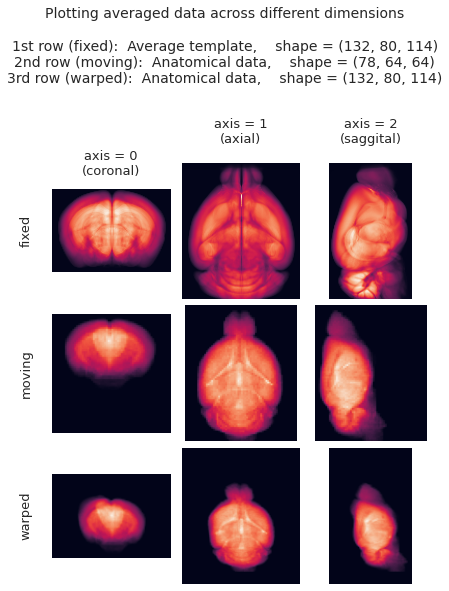

In [97]:
key = mice.get_key(4, 2)

_ = plot_registration(
    fixed=fixed,
    moving=moving_imgs[key],
    warped=warped_imgs[key],
)

In [99]:
config = Config()

n_seeds = 20
seeds = [2**i for i in range(n_seeds)]

for key, anat in mice.T1w.items():
    if key != mice.get_key(4, 2):
        continue
    
    subject, session, _ = mice.looper[key]

    moving = anat.get_data()
    moving = reorient_arr(moving)
    moving = reset_ants_img(moving)
    moving_imgs[key] = moving

    _txs = []
    _perf = []
    for seed in tqdm(seeds):
        tx = ants.registration(
            fixed=fixed,
            moving=moving,
            mask=moving.get_mask(),
            type_of_transform='SyN',
            verbose=True,
            random_seed=seed,
        )
        warped = ants.apply_transforms(
            fixed=fixed,
            moving=moving,
            transformlist=tx['fwdtransforms'],
            interpolator='linear',
        )
        mi = ants.image_mutual_information(fixed, warped)
        mi_base = ants.image_mutual_information(fixed, fixed)

        _txs.append(tx)
        _perf.append(mi/mi_base)

    best_tx = _txs[np.argmax(_perf)]
    transforms[key] = best_tx
    
    warped = ants.apply_transforms(
        fixed=fixed,
        moving=moving,
        transformlist=best_tx['fwdtransforms'],
        interpolator='linear',
    )
    warped_imgs[key] = warped
    
    mi = ants.image_mutual_information(fixed, warped)
    mi_base = ants.image_mutual_information(fixed, fixed)
    print('{:s},\tbest rel mi: {:.3f}'.format(key, mi/mi_base))

  0%|          | 0/20 [00:00<?, ?it/s]

sub-SLC04_ses-2,	best rel mi: 0.471


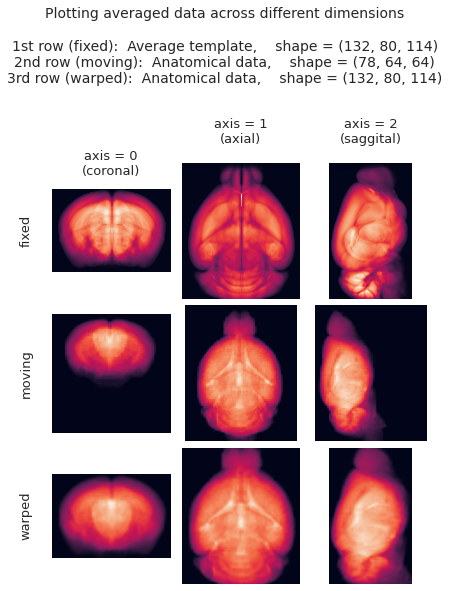

In [100]:
key = mice.get_key(4, 2)

_ = plot_registration(
    fixed=fixed,
    moving=moving_imgs[key],
    warped=warped_imgs[key],
)

### Inv mask transforms

In [101]:
masks_inv = {}
for key, best_tx in tqdm(transforms.items()):
    inv = {}
    inv['roi'] = {
        lbl: ants.apply_transforms(
            fixed=moving,
            moving=reset_ants_img(mask),
            transformlist=best_tx['invtransforms'],
            interpolator='genericLabel', )
        for lbl, mask in roi_masks.items()
    }
    _masks = [
        parcellation['mask_l'],
        parcellation['mask_r'],
        allen['root_mask'],
        allen['cerebrum_mask'],
        allen['isocortex_mask'],
    ]
    left_inv, right_inv, root_inv, cerebrum_inv, isocortex_inv = [
        ants.apply_transforms(
            fixed=moving,
            moving=reset_ants_img(mask),
            transformlist=best_tx['invtransforms'],
            interpolator='genericLabel', )
        for mask in _masks
    ]
    inv['left'] = left_inv
    inv['right'] = right_inv
    inv['root'] = root_inv
    inv['cerebrum'] = cerebrum_inv
    inv['isocortex'] = isocortex_inv
    
    masks_inv[key] = inv

  0%|          | 0/30 [00:00<?, ?it/s]

In [102]:
atlas_inv = {}
for key, val in tqdm(masks_inv.items()):
    atlas_kmeans_inv = np.zeros(moving.shape)
    for lbl, mask_inv in val['roi'].items():
        if str(allen['isocortex']['id']) not in lbl:
            continue
        region_id = int(lbl.split('-')[-1])
        atlas_kmeans_inv[mask_inv.numpy().astype(bool)] = region_id
    atlas_inv[key] = atlas_kmeans_inv

  0%|          | 0/30 [00:00<?, ?it/s]

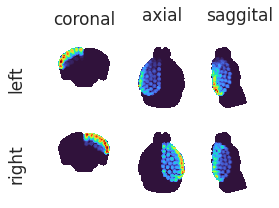

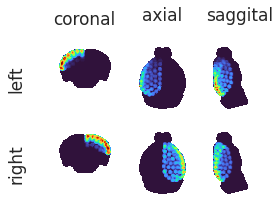

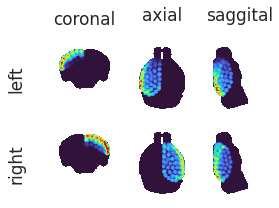

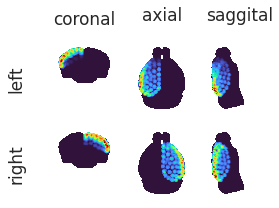

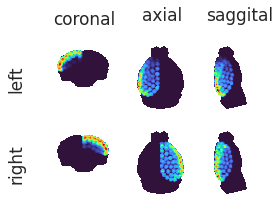

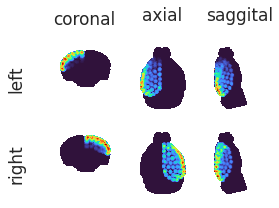

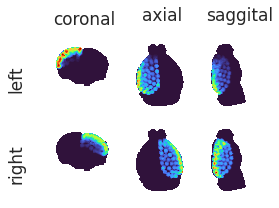

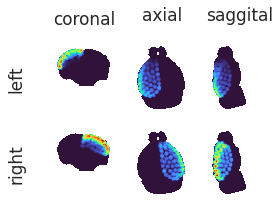

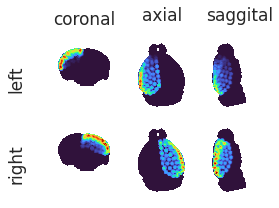

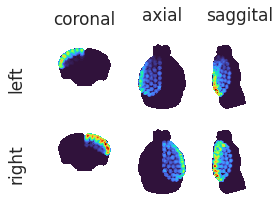

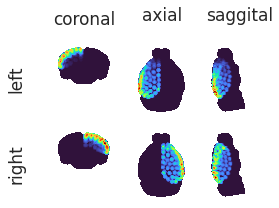

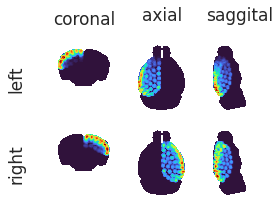

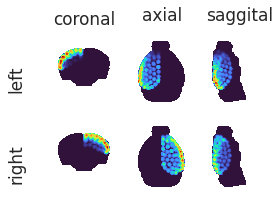

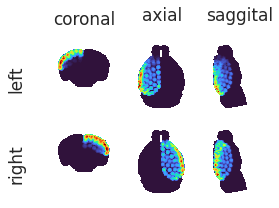

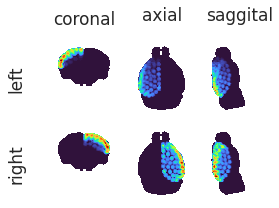

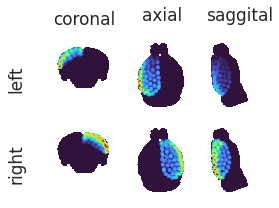

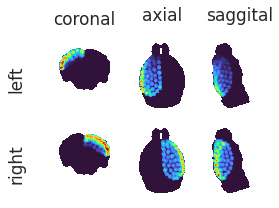

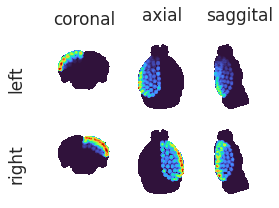

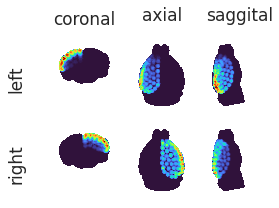

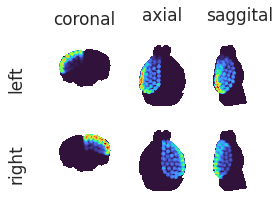

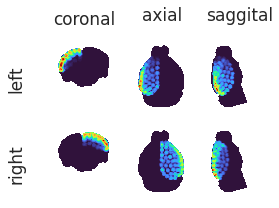

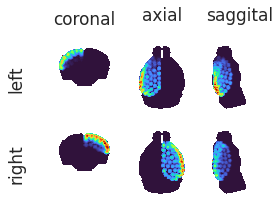

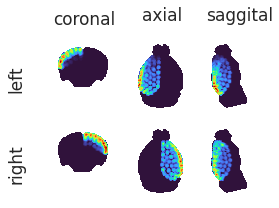

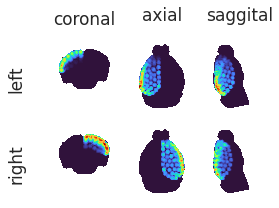

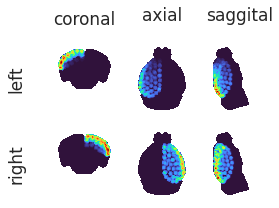

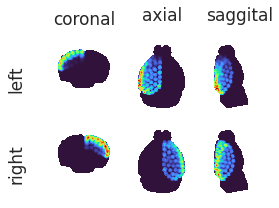

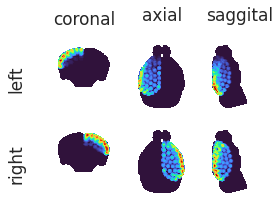

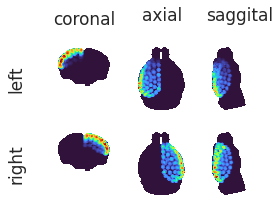

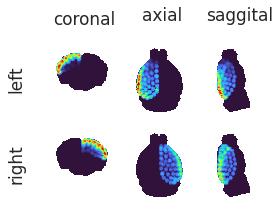

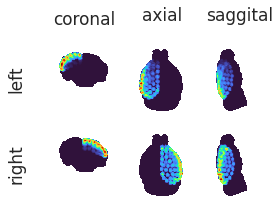

In [103]:
for key, atlas_kmeans_inv in atlas_inv.items():
    _ = plot_parcellation(
        parcellation=atlas_kmeans_inv,
        mask_l=masks_inv[key]['left'].numpy().astype(bool),
        mask_r=masks_inv[key]['right'].numpy().astype(bool),
        root_mask=masks_inv[key]['root'].numpy().astype(bool),
        figsize=(4, 3),
    )

### Load func

In [104]:
config = Config()
include_intvl = range(config.exclude, config.run_duration)

normal = True

dict_list = []
for key, bold in tqdm(mice.bold.items()):
    subject, session, run = mice.looper[key]

    x = bold.get_data()
    if bold.task != 'rest' or x is None:
        continue
    x = reorient_arr(x)
    
    key_mask = mice.get_key(subject, session)
    mask_CH = masks_inv[key_mask]['cerebrum'].numpy().astype(bool)
    
    if normal:
        mean = x[mask_CH, :].mean()
        sd = x[mask_CH, :].std()
        x = (x - mean) / sd

    # put into df
    for region_id, mask in masks_inv[key_mask]['roi'].items():
        data_dict = {
            'bold': x[mask.numpy().astype(bool), :].mean(0)[include_intvl], # TODO: how about median?
            'timepoint': range(config.run_duration*(run-1) + config.exclude, config.run_duration*run),
            'region_id': [region_id] * len(include_intvl),
            'subject': [subject] * len(include_intvl),
            'session': [session] * len(include_intvl),
            'run': [run] * len(include_intvl),
            'normal': [str(normal)] * len(include_intvl),
        }
        dict_list.append(data_dict)
df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/210 [00:00<?, ?it/s]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 62 but corresponding boolean dimension is 64

In [119]:
x.shape

(78, 62, 64, 600)

In [120]:
mask_CH.shape

(78, 64, 64)

In [121]:
x.shape

(78, 62, 64, 600)

In [105]:
df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [106]:
df.shape

(3187800, 7)

In [374]:
df.to_pickle("func_data.df")

In [107]:
df_table = {}

for key, (subject, session, run) in mice.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = selected_df.pivot(index='timepoint', columns='region_id', values='bold')

node_labels = list(df_table.values())[0].columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

In [110]:
pprint(list(df_table.keys()))

['sub-SLC01_ses-1_run-1',
 'sub-SLC01_ses-1_run-3',
 'sub-SLC01_ses-1_run-5',
 'sub-SLC01_ses-1_run-7',
 'sub-SLC01_ses-2_run-1',
 'sub-SLC01_ses-2_run-3',
 'sub-SLC01_ses-2_run-5',
 'sub-SLC01_ses-2_run-7',
 'sub-SLC01_ses-3_run-1',
 'sub-SLC01_ses-3_run-3',
 'sub-SLC01_ses-3_run-5',
 'sub-SLC01_ses-3_run-7',
 'sub-SLC02_ses-1_run-1',
 'sub-SLC02_ses-1_run-3',
 'sub-SLC02_ses-1_run-5',
 'sub-SLC02_ses-1_run-7',
 'sub-SLC02_ses-2_run-1',
 'sub-SLC02_ses-2_run-3',
 'sub-SLC02_ses-2_run-5',
 'sub-SLC02_ses-3_run-1',
 'sub-SLC02_ses-3_run-3',
 'sub-SLC02_ses-3_run-5',
 'sub-SLC02_ses-3_run-7',
 'sub-SLC03_ses-1_run-2',
 'sub-SLC03_ses-1_run-4',
 'sub-SLC03_ses-1_run-6',
 'sub-SLC03_ses-2_run-1',
 'sub-SLC03_ses-2_run-3',
 'sub-SLC03_ses-2_run-5',
 'sub-SLC03_ses-2_run-7',
 'sub-SLC03_ses-3_run-1',
 'sub-SLC03_ses-3_run-3',
 'sub-SLC03_ses-3_run-5',
 'sub-SLC03_ses-3_run-7',
 'sub-SLC04_ses-1_run-1',
 'sub-SLC04_ses-1_run-3',
 'sub-SLC04_ses-1_run-5',
 'sub-SLC04_ses-1_run-7',
 'sub-SLC04_

### Combine aaaaallll data

In [111]:
# df_list = [
#     _df for key, _df in df_table.items()
#     if mice.looper[key][0] in [6] and mice.looper[key][1] in [1]
# ]
df_combined = pd.concat(df_table.values())
df_combined.shape

(23100, 138)

In [122]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [123]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_combined, percentiles=percentiles, positive_only=False)

In [124]:
corrs.keys()

dict_keys(['percentiles', 'pearson_thresholds', 'spearman_thresholds', 'pearson', 'spearman', 'pearson_corr', 'spearman_corr'])

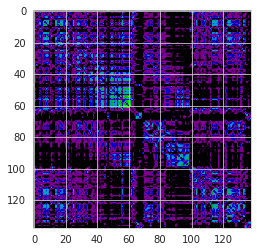

In [125]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)

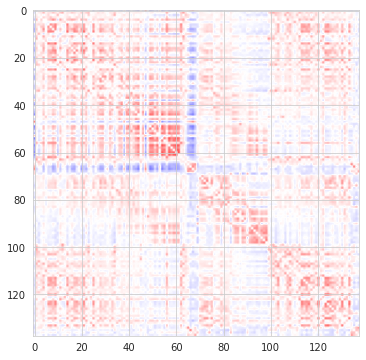

In [126]:
plt.figure(figsize=(8, 6))
plt.imshow(corrs['pearson_corr'], cmap='bwr', vmin=-1, vmax=1)

In [127]:
node_labels

{0: '0-1089',
 1: '0-315-1',
 2: '0-315-10',
 3: '0-315-11',
 4: '0-315-12',
 5: '0-315-13',
 6: '0-315-14',
 7: '0-315-15',
 8: '0-315-16',
 9: '0-315-17',
 10: '0-315-18',
 11: '0-315-19',
 12: '0-315-2',
 13: '0-315-20',
 14: '0-315-21',
 15: '0-315-22',
 16: '0-315-23',
 17: '0-315-24',
 18: '0-315-25',
 19: '0-315-26',
 20: '0-315-27',
 21: '0-315-28',
 22: '0-315-29',
 23: '0-315-3',
 24: '0-315-30',
 25: '0-315-31',
 26: '0-315-32',
 27: '0-315-33',
 28: '0-315-34',
 29: '0-315-35',
 30: '0-315-36',
 31: '0-315-37',
 32: '0-315-38',
 33: '0-315-39',
 34: '0-315-4',
 35: '0-315-40',
 36: '0-315-41',
 37: '0-315-42',
 38: '0-315-43',
 39: '0-315-44',
 40: '0-315-45',
 41: '0-315-46',
 42: '0-315-47',
 43: '0-315-48',
 44: '0-315-49',
 45: '0-315-5',
 46: '0-315-50',
 47: '0-315-51',
 48: '0-315-52',
 49: '0-315-53',
 50: '0-315-54',
 51: '0-315-55',
 52: '0-315-56',
 53: '0-315-57',
 54: '0-315-58',
 55: '0-315-59',
 56: '0-315-6',
 57: '0-315-60',
 58: '0-315-61',
 59: '0-315-62'

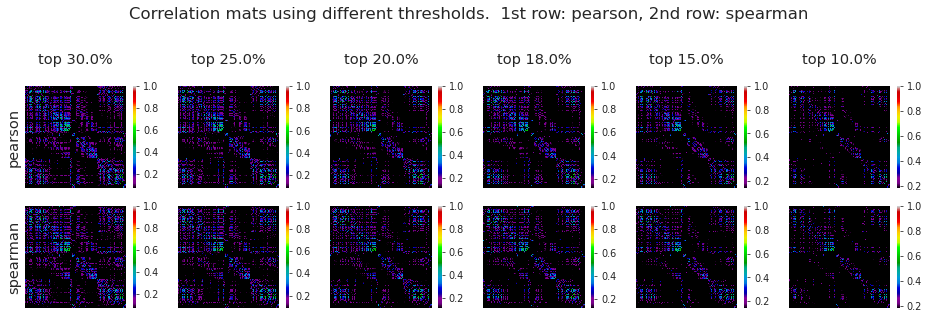

In [128]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

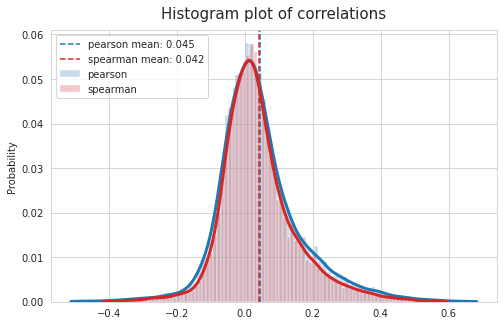

In [129]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(8, 5),
)

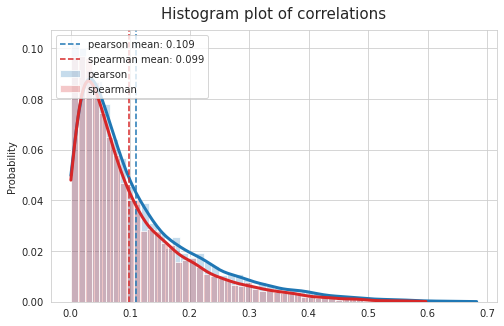

In [130]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(8, 5),
)